# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.896689,True,7.480525
1,0.735005,False,2.151096
2,1.225542,False,4.034264
3,1.292827,True,7.596582
4,1.529784,True,9.812034
...,...,...,...
995,0.204058,False,0.391702
996,0.433960,False,0.888125
997,1.488898,True,7.952415
998,0.420907,True,4.193046


<AxesSubplot: xlabel='v0'>

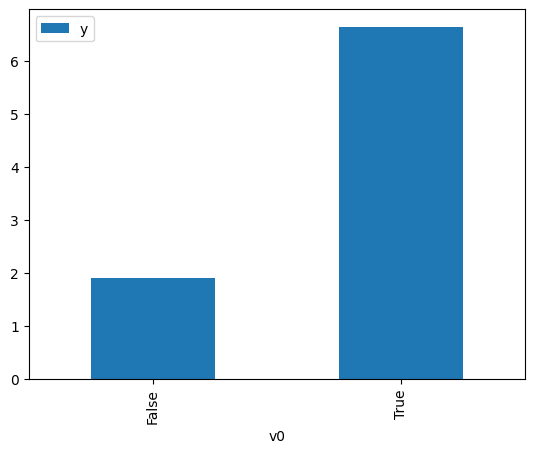

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

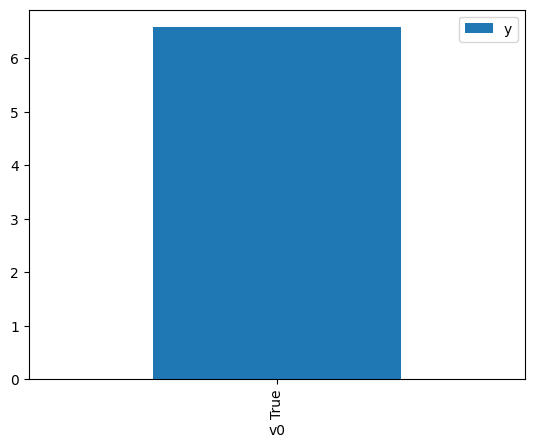

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.386786,False,-0.845863,0.604997,1.652900
1,-1.244697,False,-3.146884,0.815670,1.225985
2,0.357329,False,0.334876,0.378976,2.638687
3,-0.000479,False,0.087074,0.487152,2.052749
4,1.470435,False,2.837609,0.133491,7.491165
...,...,...,...,...,...
995,3.318281,False,7.647591,0.015434,64.791523
996,1.414422,False,1.843760,0.141708,7.056743
997,-0.568303,False,-0.809275,0.657192,1.521624
998,-0.361781,False,-1.149120,0.597584,1.673405


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.617559,True,5.941462,0.693326,1.442323
1,0.479705,True,6.191235,0.655936,1.524540
2,1.268205,True,7.528418,0.834843,1.197830
3,0.695345,True,6.292742,0.713391,1.401756
4,-0.159351,True,4.031123,0.463796,2.156119
...,...,...,...,...,...
995,1.895147,True,9.925822,0.916497,1.091111
996,1.533858,True,6.937278,0.875324,1.142434
997,2.203397,True,13.414209,0.941413,1.062233
998,-0.033787,True,6.199631,0.502553,1.989839


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.978
Model:                            OLS   Adj. R-squared (uncentered):              0.978
Method:                 Least Squares   F-statistic:                          2.195e+04
Date:                Wed, 09 Nov 2022   Prob (F-statistic):                        0.00
Time:                        17:17:08   Log-Likelihood:                         -1409.0
No. Observations:                1000   AIC:                                      2822.
Df Residuals:                     998   BIC:                                      2832.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.5051      0.035     72.488      0.000       2.437       2.573
x2             5.0413      0.052     96.971      0.000       4.939       5.143
==============================================================================
Omnibus:                        1.735   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.420   Jarque-Bera (JB):                1.724
Skew:                           0.102   Prob(JB):                        0.422
Kurtosis:                       2.988   Cond. No.                         2.53
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""